In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

In [3]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def cv_evaluate(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error)
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    for key in cv_results.keys():
        if key in ['fit_time', 'score_time']:
            continue
        print(f"{key}: {cv_results[key]}")
        print(f"{key} trung bình: {cv_results[key].mean():.3f} ± {cv_results[key].std():.3f}")
        print()

## Default KNN

In [7]:
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

preprocessor = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler())
])

knn = KNeighborsRegressor(n_neighbors=5)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                                 ('scaler', StandardScaler())])),
                ('model', KNeighborsRegressor())])

In [8]:
print("===== Holdout evaluation:=====")
print("Trainig set:")
print_metrics(*evaluate_model(pipeline, X_train, y_train))

print("\nTest set:")
print_metrics(*evaluate_model(pipeline, X_test, y_test))

print("\n===== Cross-validation evaluation:=====")
cv_evaluate(pipeline, X, y)

===== Holdout evaluation:=====
Trainig set:
MSE: 6.641
MAE: 1.957
R2: 0.862

Test set:
MSE: 9.965
MAE: 2.392
R2: 0.796

===== Cross-validation evaluation:=====
test_r2: [0.79599078 0.79134488 0.7898315  0.78342598 0.78872533]
test_r2 trung bình: 0.790 ± 0.004

test_mae: [2.38924791 2.39955432 2.43154082 2.41565896 2.42981332]
test_mae trung bình: 2.413 ± 0.017

test_mse: [ 9.92007799 10.03476323 10.17431039 10.22902201 10.37353023]
test_mse trung bình: 10.146 ± 0.157



## Grid Search CV to find optimal params

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_neighbors': np.arange(1, 20, 1),
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2, 3]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('te',
                                                         TargetEncoder(cols=['nationality'])),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'model__p': [1, 2, 3],
                         'model__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [15]:
print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best params: {'model__n_neighbors': np.int64(13), 'model__p': 1, 'model__weights': 'distance'}
Best score: 6.861223220440115


In [16]:
best_model = grid_search.best_estimator_
print("\n===== Holdout evaluation:=====")
print("Trainig set:")
print_metrics(*evaluate_model(best_model, X_train, y_train))

print("\nTest set:")
print_metrics(*evaluate_model(best_model, X_test, y_test))

print("\n===== Cross-validation evaluation:=====")
cv_evaluate(best_model, X, y)


===== Holdout evaluation:=====
Trainig set:
MSE: 0.000
MAE: 0.000
R2: 1.000

Test set:
MSE: 6.555
MAE: 1.870
R2: 0.866

===== Cross-validation evaluation:=====
test_r2: [0.86724429 0.86216477 0.86694954 0.85474932 0.85642155]
test_r2 trung bình: 0.862 ± 0.005

test_mae: [1.85616136 1.8626983  1.85958495 1.88449061 1.91250476]
test_mae trung bình: 1.875 ± 0.021

test_mse: [6.45533067 6.62885201 6.44100649 6.86034483 7.04966378]
test_mse trung bình: 6.687 ± 0.236



## What if using weights='uniform'

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

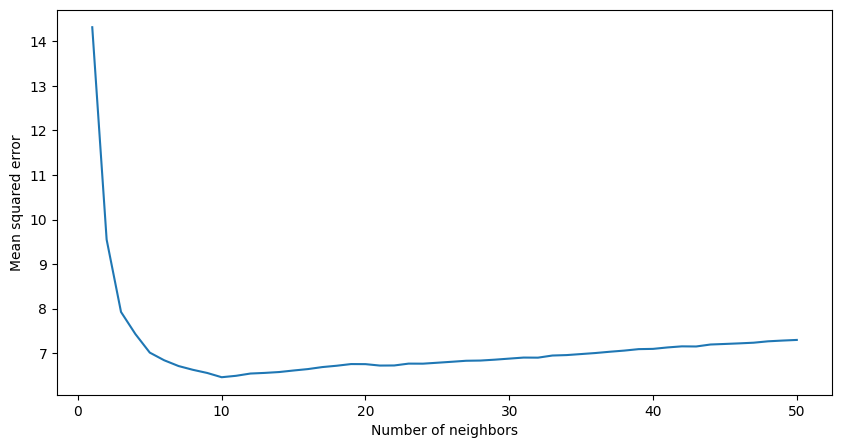

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

losses = []
min_loss = float('inf')
min_k = 0

for i in range(1, 51):
    pipe = Pipeline([
        ('encoder', TargetEncoder(cols=['nationality'])),
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(
            n_neighbors=i,
            p=1,
            weights='uniform'
        ))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    loss = np.mean((y_pred - y_val)**2)
    if loss < min_loss:
        min_loss = loss
        min_k = i
    losses.append(loss)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), losses)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean squared error')
plt.show()

In [56]:
print('Best k:', min_k)
print('Minimum loss:', min_loss)

Best k: 10
Minimum loss: 6.4569687964338796


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=min_k, p=1, weights='uniform'))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=10, p=1))])

In [58]:
print("===== Holdout evaluation:=====")
print("Trainig set:")
print_metrics(*evaluate_model(pipeline, X_train, y_train))

print("\nTest set:")
print_metrics(*evaluate_model(pipeline, X_test, y_test))

print("\n===== Cross-validation evaluation:=====")
cv_evaluate(pipeline, X, y)

===== Holdout evaluation:=====
Trainig set:
MSE: 5.535
MAE: 1.703
R2: 0.885

Test set:
MSE: 6.594
MAE: 1.878
R2: 0.865

===== Cross-validation evaluation:=====
test_r2: [0.86554469 0.85829265 0.86407925 0.85227715 0.85656883]
test_r2 trung bình: 0.859 ± 0.005

test_mae: [1.87116992 1.88671309 1.88233491 1.91217609 1.92552243]
test_mae trung bình: 1.896 ± 0.020

test_mse: [6.53797493 6.81507242 6.57995821 6.97710783 7.04243243]
test_mse trung bình: 6.791 ± 0.203



In [94]:
knn = KNeighborsRegressor(n_neighbors=min_k, p=1, weights='uniform')

In [95]:
import joblib

joblib.dump(knn, 'knn_model.pkl')
print("Mô hình KNN đã được lưu thành công dưới tên 'knn_model.pkl'")

Mô hình KNN đã được lưu thành công dưới tên 'knn_model.pkl'


In [97]:
import joblib

knn = joblib.load('knn_model.pkl')
print("Mô hình KNN đã được load từ file 'knn_model.pkl'")

Mô hình KNN đã được load từ file 'knn_model.pkl'


In [61]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring="neg_mean_squared_error"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    print("Train sizes:", train_sizes)
    print("Train scores mean:", train_scores_mean)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")

    # Tô bóng cho độ lệch chuẩn
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="blue", alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green", alpha=0.1)

    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.title("Learning Curve for KNN Regressor")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


Train sizes: [ 1435  2871  4307  5742  7178  8614 10049 11485 12921 14357]
Train scores mean: [5.04436376 5.08577011 5.28699094 5.51168095 5.27198941 5.07244718
 4.93490994 4.89214053 4.95303305 5.31995305]


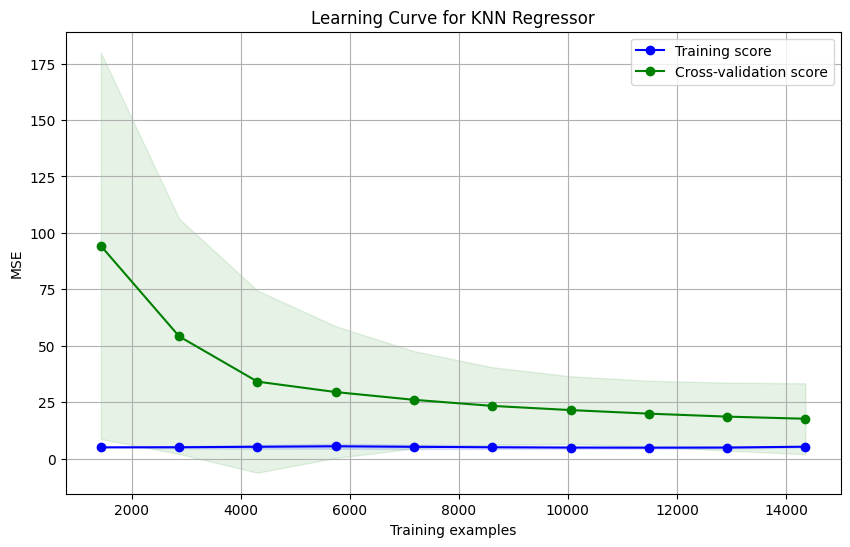

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(
        n_neighbors=min_k,
        p=1
    ))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

plot_learning_curve(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')

## Modified KNN

In [103]:
df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [105]:
print(X_train.shape, X_val.shape, X_test.shape)

(12562, 52) (2692, 52) (2693, 52)


In [106]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols=['nationality'])

X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)

In [107]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

In [108]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [109]:
X_train

array([[19, 180.00627074152098, 68.0, ..., 0, 0, 0],
       [31, 182.88, 73.9, ..., 0, 0, 1],
       [25, 190.5, 84.8, ..., 0, 0, 0],
       ...,
       [20, 175.26, 78.0, ..., 0, 0, 0],
       [39, 190.5, 78.0, ..., 0, 0, 0],
       [31, 195.58, 83.9, ..., 0, 0, 0]], dtype=object)

In [110]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Hàm tính độ hợp lệ (Validity) với ma trận khoảng cách sẵn có
def compute_validity_regression(X_train, y_train, H=5):
    # Tính toán ma trận khoảng cách giữa các điểm trong X_train
    distances = pairwise_distances(X_train)
    
    # Khởi tạo mảng validity
    validity = np.zeros(len(X_train))
    
    for i in range(len(X_train)):
        # Lấy H láng giềng gần nhất (bỏ qua chính điểm đó)
        nearest_neighbors = np.argpartition(distances[i], H+1)[:H+1]
        nearest_neighbors = nearest_neighbors[nearest_neighbors != i]  # Loại bỏ chính nó

        # Tính độ lệch chuẩn của giá trị mục tiêu của láng giềng
        neighbor_targets = y_train[nearest_neighbors]
        validity[i] = 1 / (np.std(neighbor_targets) + 0.1)  # Độ hợp lệ nghịch đảo với độ lệch chuẩn
    
    return validity

# Hàm dự đoán với Weighted KNN cho hồi quy
def weighted_knn_predict_regression(X_train, y_train, X_test, validity, K=5):
    # Tính toán ma trận khoảng cách giữa X_test và X_train
    distances = pairwise_distances(X_test, X_train)
    
    y_pred = []
    
    for i in range(len(X_test)):
        # Lấy K láng giềng gần nhất
        nearest_neighbors = np.argpartition(distances[i], K)[:K]
        
        # Tính trọng số dựa trên độ hợp lệ và khoảng cách
        d = distances[i][nearest_neighbors]
        weights = validity[nearest_neighbors] / (d + 0.5)
        weighted_average = np.dot(weights, y_train[nearest_neighbors]) / weights.sum()
        
        y_pred.append(weighted_average)
    
    return np.array(y_pred)

In [111]:
# Tính độ hợp lệ cho các mẫu trong tập huấn luyện
validity = compute_validity_regression(X_train, y_train, H=5)

y_pred = weighted_knn_predict_regression(X_train, y_train, X_val, validity, K=5)

In [114]:
print("Validation Set:")

print(f'MAE: {mean_absolute_error(y_val, y_pred):.3f}')
print(f'MSE: {mean_squared_error(y_val, y_pred):.3f}')
print(f'R2 score: {r2_score(y_val, y_pred):.3f}')

Validation Set:
MAE: 1.836
MSE: 6.911
R2 score: 0.852


In [93]:
min_loss = float('inf')
H_optimal = 0

for H in range(1, 21):
    validity = compute_validity_regression(X_train, y_train, H=H)
    y_pred = weighted_knn_predict_regression(X_train, y_train, X_val, validity, K=H)
    if mean_squared_error(y_val, y_pred) < min_loss:
        min_loss = mean_squared_error(y_val, y_pred)
        H_optimal = H

print(H_optimal)

11


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

encoder = TargetEncoder(cols=['nationality'])
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

In [99]:
validity = compute_validity_regression(X_train, y_train, H=H_optimal)

y_pred = weighted_knn_predict_regression(X_train, y_train, X_test, validity, K=H_optimal)

In [100]:
y_train_pred = weighted_knn_predict_regression(X_train, y_train, X_train, validity, K=H_optimal)

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred):.3f}')
print(f'MSE: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'R2 score: {r2_score(y_train, y_train_pred):.3f}')

print()

print('Test Set:')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'MSE: {mean_squared_error(y_test, y_pred):.3f}')
print(f'R2 score: {r2_score(y_test, y_pred):.3f}')


Training Set:
MAE: 0.234
MSE: 0.128
R2 score: 0.997

Test Set:
MAE: 1.740
MSE: 6.144
R2 score: 0.875
